In [155]:
# from pyquant.SVI import SVICalc
from importlib import reload
import pyquant.svi
reload(pyquant.svi)

from pyquant.svi import *
from pyquant.common import *
import numpy as np
import numba as nb
import matplotlib.pyplot as plt


In [156]:
bs_calc = BSCalc()

strikes = np.array([1300., 1400, 1500, 1600, 1700, 1800., 1900, 2000, 2100, 2200])
call_strikes = np.array([1800., 1900, 2000, 2100, 2200])
tau = 0.01
F = 1723.75
pvs = np.array([ 1.72375, 1.72375, 3.4475, 6.895, 26.718125, 11.204375,
                4.309375, 1.72375, 0.861875, 0.861875])

implied_vols = bs_calc.implied_vols(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)), 
    Strikes(strikes),
    Premiums(pvs)
).data

vol_smile_chain = VolSmileChain(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(implied_vols)
)
weights = CalibrationWeights(np.ones_like(vol_smile_chain.Ks))



In [157]:
svi_calc = SVICalc()

In [158]:
calibrated_params = svi_calc.calibrate(vol_smile_chain, weights)

/Users/zugzvangg/Desktop/Projects/noa/docs/quant/pyquant/svi.py:395: RuntimeWarning: invalid value encountered in sqrt
/Users/zugzvangg/Desktop/Projects/noa/docs/quant/pyquant/svi.py:362: RuntimeWarning: invalid value encountered in sqrt


In [159]:
calibrated_params.array()

array([-0.05516348,  0.19508255, -0.53059706, -0.22331506,  0.35125428])

In [160]:
svi_calc.calibration_error

1.4068043478413755e-05

In [161]:
jw_params = svi_calc._get_jump_wing_params(0.1)

In [162]:
jw_params.array()

array([0.0292075 , 0.0106822 , 5.52499778, 1.69440429, 0.02918762])

In [163]:
test_strikes = Strikes(np.linspace(strikes[0], strikes[-1], 100))

In [164]:
test_iv = svi_calc.implied_vols(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    calibrated_params
)

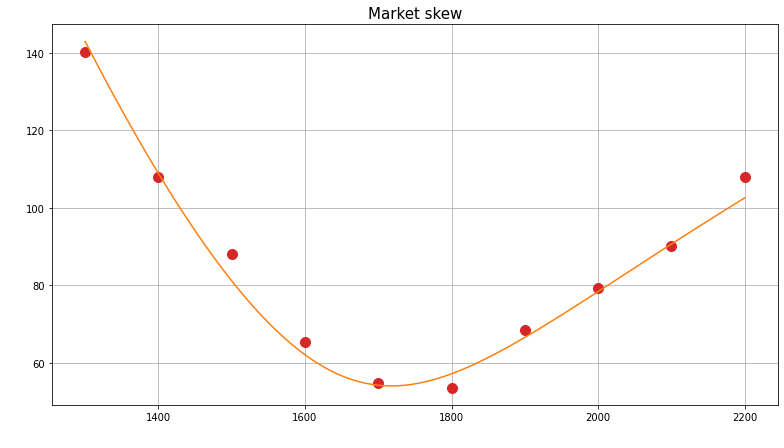

In [165]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()